In [1]:
import numpy as np
import pandas as pd 
import json
import os

In [2]:
data_dir = "../datasets/my_dataset/"

In [3]:
schema_path = os.path.join(data_dir, 'schema.json')
schema = open(schema_path, 'r')
predicate_dict = {}
ners = set()
for l_idx, line in enumerate(schema):
    tmp = json.loads(line)
    predicate_dict[tmp['predicate']] = (tmp['subjtct_type'], tmp['object_type'])
    ners.add(tmp['subjtct_type'])
    ners.add(tmp['object_type'])

In [4]:
print(len(predicate_dict))
predicate_dict

19


{'相关文物': ('遗址文化', '文物藏品'),
 '所在地': ('遗址文化/单位机构', '地点'),
 '所属时代': ('遗址文化/文物藏品/人物', '历史时代'),
 '文物尺寸': ('文物藏品', '尺寸'),
 '面积大小': ('遗址文化/单位机构', '面积'),
 '发现时间': ('遗址文化/文物藏品', '时间'),
 '保存于': ('文物藏品', '单位机构'),
 '建设时间': ('遗址文化', '时间'),
 '文保级别': ('遗址文化', '保护级别'),
 '相关建筑': ('遗址文化', '建筑'),
 '相关人物': ('遗址文化/文物藏品/人物', '人物'),
 '相关单位': ('遗址文化', '单位机构'),
 '馆藏物品': ('单位机构', '文物藏品'),
 '文化类型': ('遗址文化', '文化'),
 '成立时间': ('单位机构', '时间'),
 '文化组成': ('遗址文化', '遗址文化'),
 '相关文献': ('遗址文化/文物藏品', '书籍文献'),
 '文物重量': ('文物藏品', '重量'),
 '馆长': ('单位机构', '人物')}

In [5]:
predicate_dict.keys()

dict_keys(['相关文物', '所在地', '所属时代', '文物尺寸', '面积大小', '发现时间', '保存于', '建设时间', '文保级别', '相关建筑', '相关人物', '相关单位', '馆藏物品', '文化类型', '成立时间', '文化组成', '相关文献', '文物重量', '馆长'])

In [6]:
ners_set = set()
for _, (n1, n2) in predicate_dict.items():
    ners_set.add(n1)
    ners_set.add(n2)

In [7]:
print(len(ners_set))
ners_set

17


{'书籍文献',
 '人物',
 '保护级别',
 '单位机构',
 '历史时代',
 '地点',
 '尺寸',
 '建筑',
 '文化',
 '文物藏品',
 '时间',
 '遗址文化',
 '遗址文化/单位机构',
 '遗址文化/文物藏品',
 '遗址文化/文物藏品/人物',
 '重量',
 '面积'}

In [8]:
import re
# 处理数据

def get_data(file_path, key_word):
    with open(file_path, 'r', encoding='utf-8') as file:
        docs = []
        for l_idx, line in enumerate(file):
            doc = {}
            info = json.loads(line)
            doc['doc_key'] = str(l_idx) + key_word
            ori_sent = info['sentence']
            if len(ori_sent) > 512:
                # 超过最大长度，truncate
                print(len(ori_sent))
                ori_sent = ori_sent[:512]
            doc['sentences'] = [[ch for ch in ori_sent]] #TODO split into tokens
            doc['ner'] = [[]]
            doc['relations'] = [[]]
            if key_word == 'train':
                doc['ner'] = [[]]
                doc['relations'] = [[]]
                spos = info['spos']
                entity_set = set()
                for cur_spo in spos:
                    cur_rel = cur_spo['p']
                     # 不在schema中 e.g. 馆长
                    if cur_rel not in predicate_dict:
                        continue
                    s_ner, o_ner = predicate_dict[cur_rel]
                    sub = cur_spo['s']
                    obj = cur_spo['o']
                    sub_start_idx = ori_sent.find(sub)
                    sub_end_idx = sub_start_idx + len(sub) - 1
                    obj_start_idx = ori_sent.find(obj)
                    obj_end_idx = obj_start_idx + len(obj) - 1
                    if sub_start_idx != -1:
                        doc['ner'][0].append([sub_start_idx, sub_end_idx, s_ner])
                    if obj_start_idx != -1:
                        doc['ner'][0].append([obj_start_idx, obj_end_idx, o_ner])
                    if sub_start_idx != -1 and obj_start_idx != -1:

                        doc['relations'][0].append([sub_start_idx, sub_end_idx, obj_start_idx, obj_end_idx, cur_rel])


            docs.append(doc)
        return docs



In [9]:
data_processed_dir = "../datasets/my_dataset_processed/"
train_path = os.path.join(data_dir, 'train.json')
train_data = get_data(train_path, 'train')

with open(os.path.join(data_processed_dir, 'train.json'),"w", encoding="utf-8") as f:
    for d in train_data:
        f.write(json.dumps(d, ensure_ascii=False)+'\n')

eval_path = os.path.join(data_dir, 'eval.json')
eval_data = get_data(eval_path, 'eval')

with open(os.path.join(data_processed_dir, 'test.json'),"w", encoding="utf-8") as f:
    for d in eval_data:
        f.write(json.dumps(d, ensure_ascii=False)+'\n')


In [141]:
count = 0
for doc in eval_data:
    count += len(doc['relations'][0])
count 

742

##  baseline--UIE 参考

In [112]:
import json
import pandas as pd

examples = []
with open("../datasets/my_dataset/train.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        examples.append(json.loads(i))
train = pd.DataFrame(examples)
train ["idlength"] = [len(i) for i in train ["id"]]
train ["slength"] = [len(i) for i in train ["sentence"]]

examples = []
with open("../datasets/my_dataset/eval.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        examples.append(json.loads(i))
eval = pd.DataFrame(examples)
eval["idlength"] = [len(i) for i in eval["id"]]
eval["slength"] = [len(i) for i in eval["sentence"]]
print(train.shape,eval.shape)

(800, 5) (200, 5)


(<AxesSubplot:>, <AxesSubplot:>)

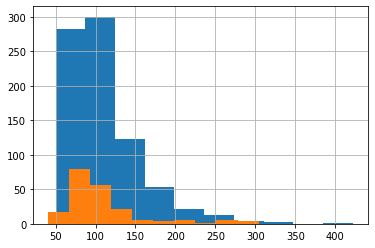

In [115]:
train["slength"].hist(),eval["slength"].hist()

In [118]:

schema_list = []
with open("../datasets/my_dataset/schema.json","r",encoding="utf-8") as f:
    for i in f.readlines():
        schema_list.append(json.loads(i))
schema_list

[{'subjtct_type': '遗址文化', 'predicate': '相关文物', 'object_type': '文物藏品'},
 {'subjtct_type': '遗址文化/单位机构', 'predicate': '所在地', 'object_type': '地点'},
 {'subjtct_type': '遗址文化/文物藏品/人物', 'predicate': '所属时代', 'object_type': '历史时代'},
 {'subjtct_type': '文物藏品', 'predicate': '文物尺寸', 'object_type': '尺寸'},
 {'subjtct_type': '遗址文化/单位机构', 'predicate': '面积大小', 'object_type': '面积'},
 {'subjtct_type': '遗址文化/文物藏品', 'predicate': '发现时间', 'object_type': '时间'},
 {'subjtct_type': '文物藏品', 'predicate': '保存于', 'object_type': '单位机构'},
 {'subjtct_type': '遗址文化', 'predicate': '建设时间', 'object_type': '时间'},
 {'subjtct_type': '遗址文化', 'predicate': '文保级别', 'object_type': '保护级别'},
 {'subjtct_type': '遗址文化', 'predicate': '相关建筑', 'object_type': '建筑'},
 {'subjtct_type': '遗址文化/文物藏品/人物', 'predicate': '相关人物', 'object_type': '人物'},
 {'subjtct_type': '遗址文化', 'predicate': '相关单位', 'object_type': '单位机构'},
 {'subjtct_type': '单位机构', 'predicate': '馆藏物品', 'object_type': '文物藏品'},
 {'subjtct_type': '遗址文化', 'predicate': '文化类型', 'object_type': 

In [120]:
def get_uie_data(df):
    prompt_datas = []
    for idx,rows in df.iterrows():
        text = rows["sentence"]
        spo_list = rows["spos"]
        entitys = []
        relations = []
        for spo in spo_list:
            pso = [(schema["subjtct_type"],schema["object_type"])for schema in schema_list if schema["predicate"] == spo['p']][0]
            if spo['s'] not in entitys:
                entitys.append([spo['s'],pso[0]])
            if spo['o'] not in entitys:
                entitys.append([spo['o'],pso[1]])
            if spo['p'] not in relations:
                relations.append([spo['p'],spo['s'],spo['o']])
        prompt_data = {}
        prompt_data["text"] = rows["sentence"]
        prompt_data["entities"] = []
        prompt_data["relations"] = []
        id_number = 0
        for entity in entitys:
            entity_pre = {}
            entity_pre['id'] = id_number
            entity_pre["start_offset"] = text.index(entity[0])
            entity_pre["end_offset"] = text.index(entity[0])+len(entity[0])
            entity_pre["label"] = entity[1]
            entity_pre["name"] = entity[0]
            prompt_data["entities"].append(entity_pre)
            id_number += 1

        for relation in relations:
            relation_pre = {}
            from_id = [e['id'] for e in prompt_data["entities"] if e['name']==relation[1]][0]
            to_id = [e['id'] for e in prompt_data["entities"] if e['name']==relation[2]][0]
            relation_pre["from_id"] = from_id
            relation_pre["to_id"] = to_id
            relation_pre["type"] = relation[0]
            prompt_data["relations"].append(relation_pre)
        prompt_datas.append(prompt_data)
    return prompt_datas

data = get_uie_data(train)
dev = get_uie_data(eval)

In [2]:
import numpy as np
import pandas as pd 
import json
import os

# NER预测文件处理
processed_f = open('../datasets/my_dataset_processed/ner_pred_result.json', 'w', encoding='utf8')
with open('./bert_models/PL-Marker-roberta-zh-10/ent_pred_test.json','r', encoding = 'utf8') as f:
    for line in f:
        processed_f.write(json.dumps(json.loads(line), ensure_ascii=False)+'\n')

processed_f.close()

In [3]:
# 后处理RE的结果
def post_process(pred_path, input_path, output_path):
    with open(pred_path, 'r', encoding='utf8') as pred_f:
        for l in pred_f:
            pred = json.loads(l)
    outputs = []
    with open(input_path, 'r', encoding='utf8') as input_f:
        for i, line in enumerate(input_f):
            line = json.loads(line)
            output = {}
            output['text'] = line['sentence']
            output['entity_spo_list'] = []
            if str(i) not in pred:
                outputs.append(output)
                continue
            cur_pred = pred[str(i)][0][1]
            for s_pos, o_pos, predicate in cur_pred:
                cur_spo = {}
                cur_spo['predicate'] = predicate
                cur_spo['subject'] = line['sentence'][s_pos[0]:s_pos[1]+1]
                cur_spo['object'] = line['sentence'][o_pos[0]:o_pos[1]+1]
                output['entity_spo_list'].append(cur_spo)
            outputs.append(output)
            
    # 写入处理后的结果
    with open(output_path, 'w', encoding='utf-8') as output_f:
        for d in outputs:
            output_f.write(json.dumps(d, ensure_ascii=False) + '\n')
            
post_process('./bert_models/re-roberta-zh-1/pred_results.json', '../datasets/my_dataset/eval.json', '../datasets/my_dataset_processed/test_pred.json')

In [4]:
# 最终整体评估
def evaluate_pred(pred_path, true_path):
    tot_recall = 0
    tot_pred = 0
    correct_count = 0
    true_results = []
    with open(true_path, 'r', encoding='utf8') as true_f:
        for line in true_f:
            true_results.append(json.loads(line))
    with open(pred_path, 'r', encoding='utf8') as pred_f:
        for idx, line in enumerate(pred_f):
            pred_line = json.loads(line)
            true_line = true_results[idx]
            tot_recall += len(true_line['spos'])
            tot_pred += len(pred_line['entity_spo_list'])
            pred_spos = [(item['subject'], item['predicate'], item['object']) for item in pred_line['entity_spo_list']]
            true_spos = [(item['s'], item['p'], item['o']) for item in true_line['spos']]
            for spo in pred_spos:
                if spo in true_spos:
                    correct_count += 1
    p = correct_count / tot_pred
    r = correct_count / tot_recall
    f1 = 2*p*r / (p+r)
    print("Precision: %f, Recall: %f, F1: %f" % (p, r, f1))
    
evaluate_pred('../datasets/my_dataset_processed/test_pred.json', '../datasets/my_dataset/eval.json')

Precision: 0.735376, Recall: 0.355795, F1: 0.479564


In [37]:
# 根据每个spo的predicate进行评估
import pandas as pd
from sklearn.metrics import classification_report
def spo_report(schema_path, pred_path, true_path):
    result = pd.DataFrame([], columns=['spo关系类别', 'Precision', 'Recall', 'F1', 'support'])
    report = {}
    schema_f = open(schema_path, 'r')
    predicate_dict = {}
    for l_idx, line in enumerate(schema_f):
        tmp = json.loads(line)
        predicate_dict[tmp['predicate']] = (tmp['subjtct_type'], tmp['object_type'])
    # 对每个类别分别统计
    for predicate in predicate_dict:
        report[predicate] = {}
        report[predicate]['tot_recall'] = 0
        report[predicate]['tot_pred'] = 0
        report[predicate]['correct_count'] = 0
    
    # 收集真实的spo
    true_results = []
    with open(true_path, 'r', encoding='utf8') as true_f:
        for line in true_f:
            true_results.append(json.loads(line))
    
    with open(pred_path, 'r', encoding='utf8') as pred_f:
        for idx, line in enumerate(pred_f):
            pred_line = json.loads(line)
            true_line = true_results[idx]
            pred_spos = [(item['subject'], item['predicate'], item['object']) for item in pred_line['entity_spo_list']]
            true_spos = [(item['s'], item['p'], item['o']) for item in true_line['spos']]
            for _,predicate,_ in true_spos:
                report[predicate]['tot_recall'] += 1
            for spo in pred_spos:
                report[spo[1]]['tot_pred'] += 1
                if spo in true_spos:
                    report[spo[1]]['correct_count'] += 1
    
    for idx, (k,v) in enumerate(report.items()):
        P = round(v['correct_count'] / v['tot_pred'], 4) if v['tot_pred']!=0 else 0.0
        R = round(v['correct_count'] / v['tot_recall'],4) if v['tot_recall'] !=0 else 0.0 
        F = round((2 * P * R) / (P + R),4) if (P + R)!=0 else 0.0
        S = v['tot_recall']
        result.loc[idx, :] = [k, P, R, F, S]
    return result
classification_report = spo_report("../datasets/my_dataset/schema.json", '../datasets/my_dataset_processed/test_pred.json', '../datasets/my_dataset/eval.json')
classification_report

,spo关系类别,Precision,Recall,F1,support
0,相关文物,0.4286,0.4688,0.4478,32
1,所在地,0.5,0.25,0.3333,48
2,所属时代,0.6941,0.4436,0.5413,133
3,文物尺寸,0.8534,0.4008,0.5454,247
4,面积大小,0.7778,0.6364,0.7,11
5,发现时间,0.7143,0.3333,0.4545,30
6,保存于,0.9118,0.25,0.3924,124
7,建设时间,0.0,0.0,0.0,0
8,文保级别,0.75,0.3,0.4286,10
9,相关建筑,0.0,0.0,0.0,2
